
*This file is associated to the manuscript*

#Accurate DOSY measure for out-of-equilibrium systems using permutated DOSY (*p*-DOSY)

*Maria Oikonomou, Julia Asencio-Hernández, Aldrik H. Velders, Marc-André Delsuc*

 this is a iPython Notebook document 

In [1]:
# program initialization #
%pylab inline
import sys
import numpy as np
import scipy as sci
import pandas as pd
from IPython.display import HTML, display_html, Latex, display_latex
def print_h(t): display_html(HTML(t))
def paral_h(t1,t2,c1,c2):
    print_h( "<table><tr><td><h3>%s</h3>%s</td><td><h3>%s</h3>%s</td></tr></table>"% \
            (t1,c1.to_html(),t2,c2.to_html()) )
def print_l(t): display_latex(Latex(t))
def paral_l(t1,t2,c1,c2):
    print_l( "%s\\%s\\%s\\%s\\"%(t1,c1.to_latex(),t2,c2.to_latex()) )
def parallel(t1,t2,c1,c2):
    paral_h(t1,t2,c1,c2)
TheFig = 1
def Fig(caption=None):
    global TheFig
    print_h("<b>Figure S%d</B>"%TheFig)
    TheFig += 1
    if caption:
        print_h("<i>%s</i>"%caption)
# show system version #
ver = sys.version.split('|')
print_h("""<p><i>this script is written in python, it requires the scientific libraries defined below<br/>
it was used with the "{4}" distribution, with the following library versions</i></p>
<ul><li>Python {0}<li>numpy {1}<li>scipy {2}<li>pandas {3} <i>(only for table output)</i></ul>""".format( \
    ver[0], np.__version__, sci.__version__, pd.__version__, ver[1]))

Populating the interactive namespace from numpy and matplotlib


this script is written in python, it requires the scientific libraries defined below 
it was used with the "Anaconda 2.2.0 (x86_64)" distribution, with the following library versions 
 Python 2.7.9 numpy 1.9.2 scipy 0.15.1 pandas 0.15.2 (only for table output)

---
This documents presents simulations of the *p*-DOSY protocole in various experimental conditions, and check its robustness.

The first part install the program that we will be used, and the second part performs statistical tests of the *p*-DOSY protocole.

##simulation of a DOSY experiment

First create the `DOSYsignal()` function that simulates the response of a monodisperse with diffusion coefficient $D$ to the regular STE DOSY experiment.

DOSY signal $I$ is given by 
$$ I = I_o e^{-D \gamma^2 g^2 \delta^2 (\Delta-\frac{\delta}{3})}    $$

We also def the `gradientlist()` utility function which defines a linearly increased Pulsed Field Gradient list.

Figure S1

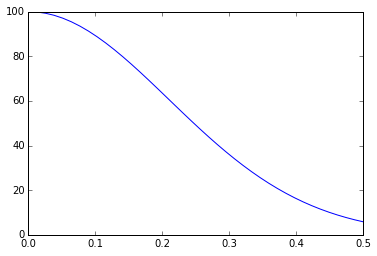

In [2]:
def DOSYsignal(grad, io, diff, delta, Delta):
    "return DOSY intensity - grad or/and io can be arrays"
    gamma = 26.7522128E7  #rad/Tesla - assume 1H spectroscopy
    q = gamma*grad*delta
    I = io * exp(-diff*(Delta-delta/3)*q**2)
    return I
def gradientlist(N, Gmax=0.5):
    "create a range of N gradients from 0 to Gmax expressed in T/m - assumed to be 0.5 T/m max"
    # 1G/cm = 1E-4/1E-2 = 1E-2 T/m
    return linspace(0,Gmax,N)
# test it and draw the DOSY signal.
NbGrad = 40
GRAD = gradientlist(NbGrad)
D = 400E-12                          # 400\mu m^2 sec^{-1}
Io = 100.0
delta = 2E-3
DELTA = 1E-1
I = DOSYsignal(GRAD, Io, D, delta, DELTA)
figsize(6,4)
plot(GRAD, I)
Fig()

## fitting procedure
The simulated data will be subjected to a least-square fit, using the `scipy.optimize.leastsq` library function which implements the Levenberg-Marquardt method.


`DOSYfit()` function takes the experimental data $I_{exp}$, the parameters.
Il will used to fit $I_o$ and $D$.

Figure S2

Fitted values : Io = 99.6   D = 4.0187e-10 


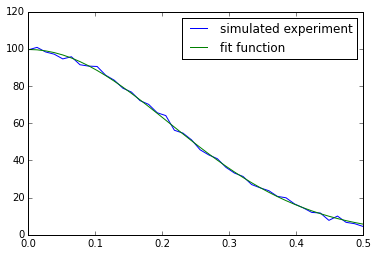

In [3]:
def DOSYfit(grad, iexp, delta, Delta):
    "perform a fit of the experimental data iexp, given delta, Delta, grad parameters"
    from scipy.optimize import leastsq
    def residu(Param, grad, iexp, delta, Delta):
        "the residue function fitted by leastsq - fitted parameters are in Param"
        io, diff = Param
        return iexp - DOSYsignal(grad, io, diff, delta, Delta)
    initial = [iexp.max(), 10E-10]   # initial guess for Io and D
    # do the fit
    p1 = leastsq(residu, initial, args=(grad, iexp, delta, Delta), Dfun=None, full_output=0) 
    return p1[0]
#and test it
Iexp = DOSYsignal(GRAD, Io, D, delta, DELTA) + 1.0*random.randn(NbGrad) # add gaussian noise
res = DOSYfit(GRAD, Iexp, delta, DELTA)
plot(GRAD, Iexp, label='simulated experiment')
plot(GRAD, DOSYsignal(GRAD, res[0], res[1], delta,  DELTA), label='fit function')
l = legend()
Fig()
print "Fitted values : Io = %.1f   D = %.6g "%tuple(res)

##Monte-Carlo analysis
We can run a simple Monte-Carlo analysis to check the error propagation of the fitting procedure, from experimental errors in $I_{exp}$ to error on the estimate of the diffusion coefficient $D$.

The `MC()` function performs this task

In [4]:
def MC(grad, io, diff, delta, Delta, noise, nmc):
    """
    perform a MonteCarlo run, for nmc trials, adding noise to the theoretical signal
    return an array of the fitted Diff values
    
    grad : the gradient list
    io : the Io intensity, a constant or an array describing the evolution
    diff : the diffusion coefficient to simulate
    delta, Delta : the parameters of the DOSY experiment
    noise : the experimental noise added to the simulation
            as a normal centered error with variance "noise"
    nmc : the number of Monte-Carlo trials
    """
    I = DOSYsignal(grad, io, diff, delta, Delta)
    Dfitted = []
    for i in range(nmc):
        iexp = I + noise*random.randn(len(I))   # add noise for testing
        p = DOSYfit(grad, iexp, delta, Delta)
        Dfitted.append(p[1])
    return array(Dfitted)

The histogram of the result of a MC analysis is shown for a noise level of 3%

`NMC` is used as a global parameter for the number of trials of the Monte-Carlo procedure.

Figure S3

<Dfitted> = 4.00192e-10 +/- 9.12907e-12


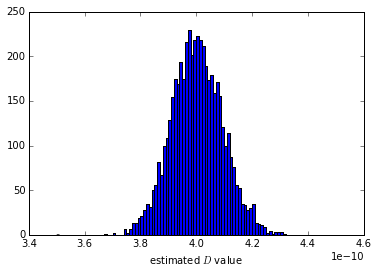

In [5]:
NMC = 5000
Df = MC(GRAD, Io, D, delta, DELTA, noise=3.0, nmc=NMC)

hist(Df,bins=100,range=(3.5E-10,4.5E-10))
xlabel("estimated $D$ value")
Fig()
print "<Dfitted> = %6g +/- %4g"%(Df.mean(), Df.std())   # errors are given as standard deviation

##dependence on noise level
Running Monte-Carlo tests, we can follow the dependence of the parameter estimate with respect to the amount of experimental noise. Result are given as mean $<D>$ and standard deviation $\sigma_D$ computed over the set of MC trials.
Results are presented in tabulated values and by histograms.


Figure S4

,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,400.000162,0.300227
2,0.3,399.993612,0.9385833
3,1,400.024806,3.023371
4,3,400.292345,8.97242


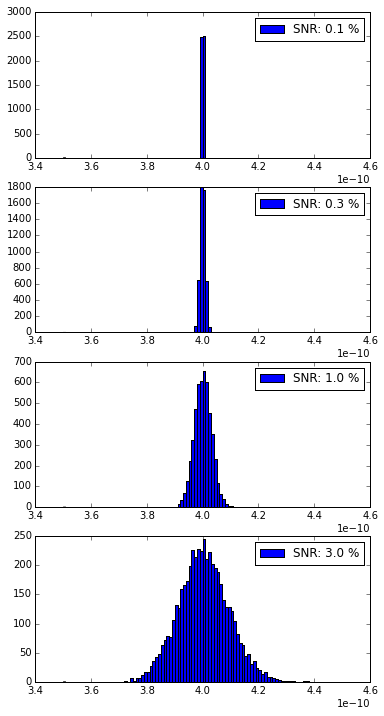

In [6]:
NbGrad = 40
GRAD = gradientlist(NbGrad)
Diff = 400E-12                          # 400\mu m^2 sec^{-1}
Io = 100.0
Dl = []
eDl = []
noiselist = [0.1, 0.3, 1.0, 3.0]        # the list of noise intensenties
nn = len(noiselist)
figsize(6,nn*3)
for i in range(nn):
    noise = noiselist[i]
    Darray = MC(GRAD, Io, Diff, delta, DELTA, noise=noise, nmc=NMC)
    Dl.append(Darray.mean())
    eDl.append(Darray.std())
    subplot(nn,1,i+1)
    hist(Darray,bins=100,range=(3.5E-10,4.5E-10), label="SNR: %.1f %%"%(noise))
    legend()
def showMC(MClist, Dl, eDl, MClabel):
    "build a pandas DataFrame from MC analysis, and display results"
    df = pd.DataFrame()
    df[MClabel]=["theo."] + MClist
    df["$<D>10^{-12}\mu m^2/sec^{-1}$"] = 1E12*array([Diff,] + Dl)
    df["$\sigma_D$"] = ["-",] + list( 1E12*array(eDl) )
    df.set_index(MClabel)
    return df

Fig()
showMC(noiselist, Dl, eDl, "Noise (%)")

#simulation for an out-of equilibrium system
With this approach, we can simulate the DOSY experiment on an evolving system.
Here the concentration is varying during the measure, which is equivalent to varying $I_o$.
We are testing several model of out-of-equilibrium systems :
 - first order decay
 - first order appearance
 - first order transient
 - second order decay

For all case, the standard approach and the *p*-DOSY are compared by running Monte-Carlo tests.
With the dependence of the results on the noise-level, and on the number of samples. 

## for a species disappearing with a first order kinetics
we define the `KinDecay()` function which simulate the concentration evolution of a species decaying with a first order kintetics :
$$
[A](t) = [A]_o e^{ \frac {-t}{T_{kin}} }
$$

Figure S5

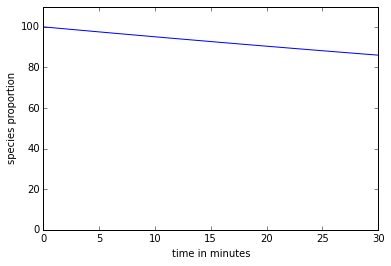

In [7]:
def KinDecay(N, Tkin, duration=30.0):
    """
    computes the concentration variation upon kinetics
    Tkin : time constant of the kinetics, in minutes
    duration : duration of the experiment, in minutes,
                assume a 30 min measure if duration not given
    """
    t = linspace(0,duration,N)   # time in minutes
    return t, 100*exp(-t/Tkin)
t,Io = KinDecay(40, 200)
figsize(6,4)
plot(t, Io)
ylim(ymin=0.0, ymax=110)
xlabel("time in minutes")
l = ylabel("species proportion")
Fig()

We can now redo the MC analysis on this system.

Figure S6

,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,430.419563,0.3369839
2,0.3,430.415705,1.016181
3,1,430.493338,3.456056
4,3,430.582635,10.34541


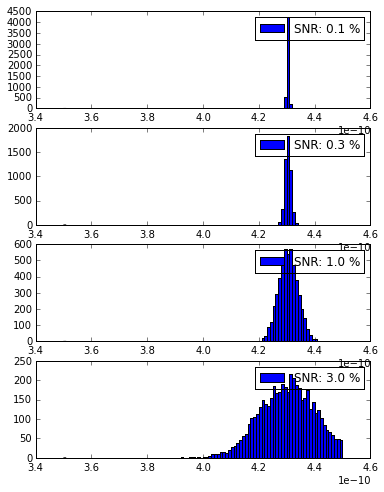

In [8]:
NbGrad = 40
GRAD = gradientlist(NbGrad)
t,Io = KinDecay(NbGrad, 200)
Diff = 400E-12                          # 400\mu m^2 sec^{-1}
Dl = []
eDl = []
noiselist = [0.1, 0.3, 1.0, 3.0]
nn = len(noiselist)
figsize(6,nn*2)
for i in range(nn):
    noise = noiselist[i]
    Darray = MC(GRAD, Io, Diff, delta, DELTA, noise=noise, nmc=NMC)
    Dl.append(Darray.mean())
    eDl.append(Darray.std())
    subplot(nn,1,i+1)
    hist(Darray,bins=100,range=(3.5E-10,4.5E-10), label="SNR: %.1f %%"%(noise))
    legend()
Fig()
showMC(noiselist, Dl, eDl, "Noise (%)")

Note the systematic biais upward

### apply Random permutation
We now simulate the *p*-DOSY approach, by randomizing the gradient list while keeping everything else identical.
We use the library function `random.permutation()` to randomize the gradient list.


In [9]:
GRAD = gradientlist(NbGrad)
GRADR = random.permutation(GRAD)
Ii = DOSYsignal(GRAD, 100.0, Diff, 1E-3, 4E-1)
I = DOSYsignal(GRAD, Io, Diff, 1E-3, 4E-1)
Ir = DOSYsignal(GRADR, Io, Diff, 1E-3, 4E-1)

To exemplify the effect of the randomization on this evolving system, we draw 
 - the unperturbed decay, that would be observed if to evolution was taking place
 - the actual decay with the evolution taking place
 - the effect of the randomization on this actual decay

Figure S7

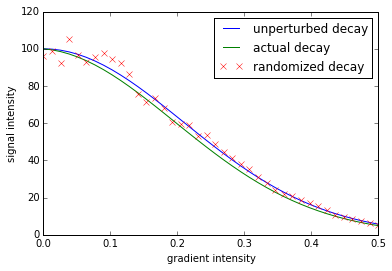

In [10]:
figsize(6,4)
plot(GRAD, Ii, label='unperturbed decay')
plot(GRAD, I, label='actual decay')
# for display, let us scale Ir which is slightly smaller
plot(GRADR, 100*Ir/Io.mean(),'x', label='randomized decay')
xlabel("gradient intensity")
ylabel("signal intensity")
l = legend()
Fig()

Note how the actual decay (green), perturbed by the species evolution, is shifted from the unperturbed one.
Note also, how the randomisation of the gradient list creates an additive measure noise.

We define `MC2()` a function that performs Monte-Carlo test by randomizing both the added synthetic noise and the permutation of the gradient list.

In [11]:
def MC2(grad, io, diff, delta, Delta, noise, nmc):
    """
    perform a MonteCarlo run, for NMC trials, adding noise to the theoretical signal
    return an array of the fitted D values
    """
    Dfitted = []
    for i in range(nmc):
        gradrand = random.permutation(grad)
        I = DOSYsignal(gradrand, io, diff, delta, Delta)
        Iexp = I + noise*random.randn(len(I))   # add noise for testing
        p = DOSYfit(gradrand, Iexp, delta, Delta)
        Dfitted.append(p[1])
    return array(Dfitted)

It will be used to make the Monte-Carlo analysis of the *p*-DOSY protocole.

Figure S8

,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,400.032085,7.180575
2,0.3,400.086666,7.138017
3,1,400.141187,7.943178
4,3,400.038940,12.20623


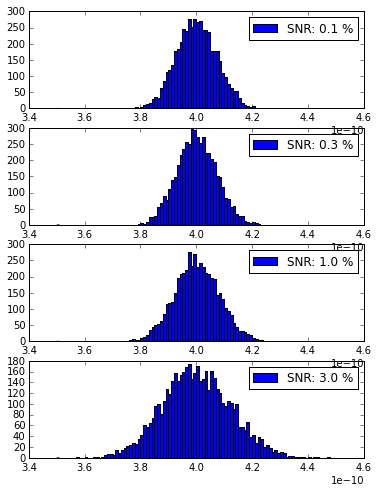

In [12]:
Dl = []
eDl = []
df = pd.DataFrame()
noiselist = [0.1, 0.3, 1.0, 3.0]
nn = len(noiselist)
figsize(6,nn*2)
for i in range(nn):
    noise = noiselist[i]
    Darray = MC2(GRAD, Io, Diff, delta, DELTA, noise=noise, nmc=NMC)
    Dl.append(Darray.mean())
    eDl.append(Darray.std())
    subplot(nn,1,i+1)
    hist(Darray,bins=100,range=(3.5E-10,4.5E-10), label="SNR: %.1f %%"%(noise))
    legend()
Fig()
showMC(noiselist, Dl, eDl, "Noise (%)")

### effect of the length of the gradient  list
We can also look at the effect of varying the number of gradients for a given experiment.
Here, we consider the total experimental time is constant, so less transients are accumulated for a single transient when more gradients are sampled.

In an NMR experiment, the signal to noise grows in $\sqrt{N}$ where $N$ is the number of accumulated transients.
So at constant total time, the number of transients varies as $1/N_G$ where $N_G$ is the number of sampled gradients, and the noise in each experiment varies in $\sqrt{N_G}$.

Figure S9

,Grad length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,400.289755,10.7648
2,40,400.059154,7.550897
3,80,399.934155,5.413719
4,160,400.012423,4.192748
5,320,399.975505,3.355673


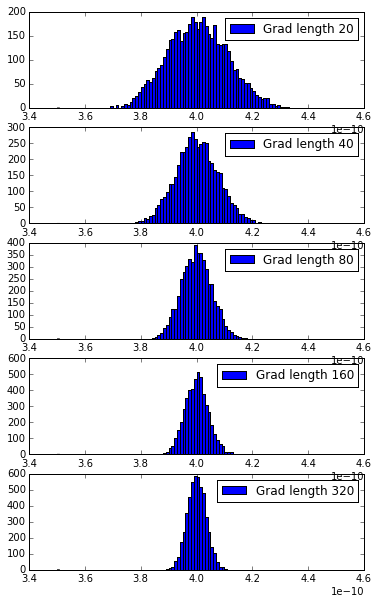

In [13]:
Dl = []
eDl = []
df = pd.DataFrame()
gradlength = [20, 40, 80, 160, 320]
noise = 0.5
figsize(6,5*2)
for i in range(5):
    ng = gradlength[i]
    G = gradientlist(ng)
    t,io = KinDecay(ng, 200)
    Darray = MC2(G, io, Diff, delta, DELTA, noise=noise*sqrt(ng/20.), nmc=NMC)
    Dl.append(Darray.mean())
    eDl.append(Darray.std())
    subplot(5,1,i+1)
    hist(Darray,bins=100,range=(3.5E-10,4.5E-10), label="Grad length %d"%(ng))
    legend(loc=0)
Fig()
showMC(gradlength, Dl, eDl, "Grad length")

It can clearly be observed that a larger number of gradients - acquired at a constant time - improves the quality of the analysis. However, no bias is observed, even at a low number of gradients.

# comparing approaches
For each kind of varying system, we will compare side-by-side the regular approach and the *p*-DOSY approach, and follow the dependence on the noise level and on the nuber of gradients.

Histograms are not shown, but the mean value $<D>$ and the variance $\sigma_D$, both tabulated and plotted.

## dependence on noise level

In [14]:
NbGrad = 40
GRAD = gradientlist(NbGrad)
t,Io = KinDecay(NbGrad, 200)
Diff = 400E-12                          # 400\mu m^2 sec^{-1}

For convinience, we define two utility functions `depnoise()` and `depglength()` that perform the comparison of DOSY and *p-DOSY* by running  MC and plotting the output

Figure S10

Comparison of DOSY and p-DOSY for different noise level

,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,430.416199,0.343427
2,0.3,430.415108,1.018592
3,1,430.365210,3.360089
4,3,430.782590,10.08406
,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,400.082364,7.137242
2,0.3,400.030553,7.120346
3,1,400.198564,7.95937


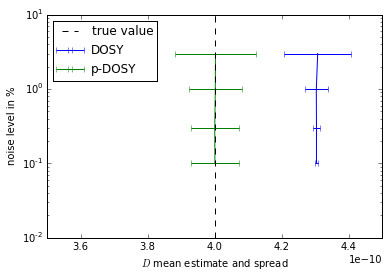

In [15]:
def depnoise():
    Fig("Comparison of DOSY and p-DOSY for different noise level")

    Dl = []
    eDl = []
    noiselist = [0.1, 0.3, 1.0, 3.0]
    nlength = len(noiselist)
    figsize(6,4)
    for i in range(nlength):
        nn = noiselist[i]
        Darray = MC(GRAD, Io, Diff, delta, DELTA, noise=nn, nmc=NMC)
        Dl.append(Darray.mean())
        eDl.append(Darray.std())
    errorbar(Dl, noiselist, xerr=eDl, label="DOSY")
    dfn = showMC(noiselist, Dl, eDl, "Noise (%)")

    Dl = []
    eDl = []
    for i in range(nlength):
        nn = noiselist[i]
        Darray = MC2(GRAD, Io, Diff, delta, DELTA, noise=nn, nmc=NMC)
        Dl.append(Darray.mean())
        eDl.append(Darray.std())
    errorbar(Dl, noiselist, xerr=eDl, label="p-DOSY")
    dfg = showMC(noiselist, Dl, eDl, "Noise (%)")

    semilogy([Diff,Diff],[0.01,10],'k--',label="true value")
    xlim((3.5E-10,4.5E-10))
    xlabel("$D$ mean estimate and spread")
    ylabel("noise level in %")
    l=legend(loc=0)
    parallel("DOSY","<i>p</i>-DOSY",dfn,dfg)
depnoise()

## dependence on gradient length

Figure S11

Comparison of DOSY and p-DOSY for different gradient list length

,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,430.915886,1.477357
2,40,430.441549,1.446952
3,80,430.191463,1.415701
4,160,430.056807,1.423773
5,320,430.009372,1.423382
,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,400.295823,10.7183
2,40,399.885047,7.265762


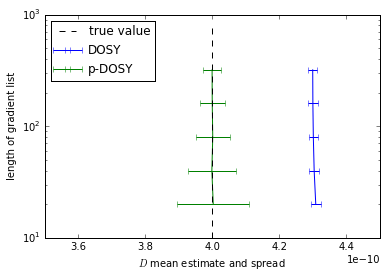

In [16]:
def depglength(Kin):
    "call to Kin(N) creates the concentration evolution to test"
    Fig("Comparison of DOSY and p-DOSY for different gradient list length")
    Dl = []
    eDl = []
    gradlength = [20, 40, 80, 160, 320]
    noise = 0.3
    figsize(6,4)
    for ng in gradlength:
        G = gradientlist(ng)
        t,io = Kin(ng)
        Darray = MC(G, io, Diff, delta, DELTA, noise=noise*sqrt(ng/20.), nmc=NMC)
        Dl.append(Darray.mean())
        eDl.append(Darray.std())
    errorbar(Dl, gradlength, xerr=eDl,label="DOSY")
    dfn = showMC(gradlength, Dl, eDl, "Grad Length")

    Dl = []
    eDl = []
    for ng in gradlength:
        G = gradientlist(ng)
        t,io = Kin(ng)
        Darray = MC2(G, io, Diff, delta, DELTA, noise=noise*sqrt(ng/20.), nmc=NMC)
        Dl.append(Darray.mean())
        eDl.append(Darray.std())
    errorbar(Dl, gradlength, xerr=eDl, label="p-DOSY")
    semilogy([Diff,Diff],[10,800],'k--',label="true value")
    xlim((3.5E-10,4.5E-10))
    xlabel("$D$ mean estimate and spread")
    ylabel("length of gradient list")
    l=legend(loc=0)
    dfg = showMC(gradlength, Dl, eDl, "Grad Length")
    parallel("DOSY","<i>p</i>-DOSY",dfn,dfg)

from functools import partial
depglength(partial(KinDecay, Tkin=200))

## same comparison on species appearing with first order kinetics

we define the `KinAppear()` function which simulate the concentration evolution of a species appearing with a first order kintetics. The `timeoffset` parameter allows not vanishing small concentrations.
$$
[B](t) = [B]_o \left [ 1 - e^{ \frac {-t}{T_{kin}} } \right ]
$$

Figure S12

Evolution of the concentration of a appearing species

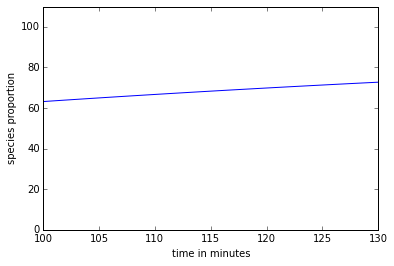

In [17]:
def KinAppear(N, Tkin, duration=30.0, timeoffset=100):
    """
    computes the concentration variation upon kinetics
    Tkin : time constant of the kinetics, in minutes
    duration : duration of the experiment, in minutes,
       assume a 30 min measure if duration not given
    timeoffset : offset since start of kinetics
    """
    t = linspace(0,duration,N)+timeoffset    # time in minutes
    return t, 100*(1-exp(-(t)/Tkin))
t,Io = KinAppear(40, 100)
figsize(6,4)
plot(t, Io)
ylim(ymin=0.0, ymax=110)
xlabel("time in minutes")
l = ylabel("species proportion")
Fig("Evolution of the concentration of a appearing species")

In [18]:
NbGrad = 40
GRAD = gradientlist(NbGrad)
t,Io = KinAppear(NbGrad, 100)
Diff = 400E-12                          # 400\mu m^2 sec^{-1}

Figure S13

Comparison of DOSY and p-DOSY for different noise level

,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,371.624797,0.4219201
2,0.3,371.609897,1.301637
3,1,371.722106,4.275335
4,3,371.516167,12.72145
,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,400.171518,6.665228
2,0.3,400.074909,6.888279
3,1,400.110471,7.92396


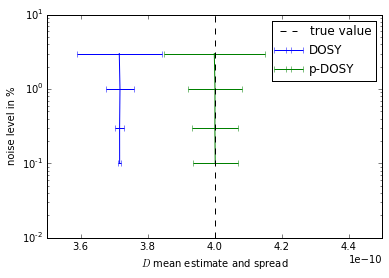

In [19]:
depnoise()

Figure S14

Comparison of DOSY and p-DOSY for different gradient list length

,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,371.181280,1.816653
2,40,371.642939,1.789171
3,80,371.865662,1.806418
4,160,371.978047,1.794107
5,320,372.011210,1.823453
,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,400.273698,10.02661
2,40,400.062082,6.987192


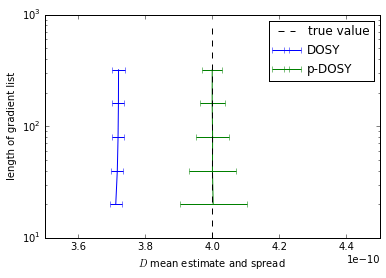

In [20]:
depglength(partial(KinAppear, Tkin=100))

## comparison for a transient species
we define the `KinTrans()` function which simulates the concentration evolution of a transient species.
$$
[C](t) = [C]_o \left [ 1 - e^{ \frac {-t}{T_{kon}} } \right ] e^{ \frac {-t}{T_{koff}} }
$$

Figure S15

Evolution of the concentration of a transient species

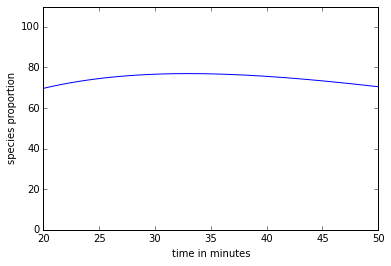

In [21]:
def KinTrans(N, Tkon, Tkoff, duration=30.0, timeoffset=50):
    """
    computes the concentration variation upon kinetics
    Tkin : time constant of the kinetics, in minutes
    duration : duration of the experiment, in minutes,
      assume a 30 min measure if duration not given
    timeoffset : offset since start of kinetics
    """
    t = linspace(0,duration,N)+timeoffset   # time in minutes
    return t, 200*(1-exp(-t/Tkon))*exp(-t/Tkoff)
t,Io = KinTrans(40, 30, 60, timeoffset=20)
figsize(6,4)
plot(t, Io)
ylim(ymin=0.0, ymax=110)
xlabel("time in minutes")
l = ylabel("species proportion")
Fig("Evolution of the concentration of a transient species")

In [22]:
NbGrad = 40
GRAD = gradientlist(NbGrad)
t,Io = KinTrans(NbGrad, 30, 60, timeoffset=20)
Diff = 400E-12                          # 400\mu m^2 sec^{-1}

Figure S16

Comparison of DOSY and p-DOSY for different noise level

,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,382.840519,0.3748871
2,0.3,382.836982,1.132871
3,1,382.809169,3.723301
4,3,383.075020,11.25193
,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,400.021219,4.569171
2,0.3,400.140386,4.741063
3,1,399.928268,6.221957


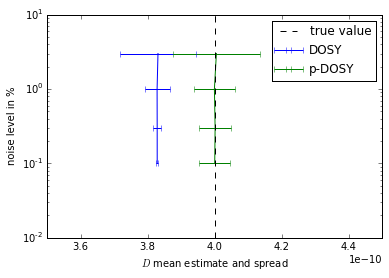

In [23]:
depnoise()

Figure S17

Comparison of DOSY and p-DOSY for different gradient list length

,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,381.558255,1.59243
2,40,382.849596,1.60943
3,80,383.434620,1.616352
4,160,383.787709,1.609313
5,320,383.943981,1.591263
,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,400.047812,7.128104
2,40,400.018428,4.959802


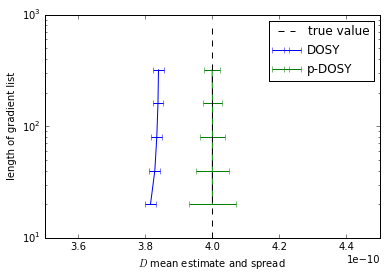

In [24]:
depglength(partial(KinTrans, Tkon=30, Tkoff=60, timeoffset=20))

## comparison for a species decaying with a second order kinetics
we define the `KinSecond()` function which simulates the concentration evolution of a species decaying with a second order kinetics, as found for instance in adsoprtion studies.

$$
[D](t) =  \frac {[D]_o}{1 + \frac {2t} {T_2}} 
$$

Figure S18

Evolution of the concentration of a second order kinetics

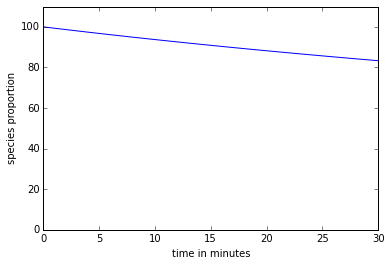

In [25]:
def KinSecond(N, T2, duration=30.0):
    """
    computes the concentration variation upon 2nd order kinetics
    T2 : time constant of the kinetics, in minutes
    duration : duration of the experiment, in minutes,
      assume a 30 min measure if duration not given
    """
    t = linspace(0,duration,N)      # time in minutes
    return t, 100/ (1+2*t/T2)
t,Io = KinSecond(40, 300)
figsize(6,4)
plot(t, Io)
ylim(ymin=0.0, ymax=110)
xlabel("time in minutes")
l = ylabel("species proportion" )
Fig("Evolution of the concentration of a second order kinetics ")

In [26]:
NbGrad = 40
GRAD = gradientlist(NbGrad)
t,Io = KinSecond(40, 300)
Diff = 400E-12                          # 400\mu m^2 sec^{-1}

Figure S19

Comparison of DOSY and p-DOSY for different noise level

,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,438.259629,0.360931
2,0.3,438.258656,1.057097
3,1,438.297983,3.475837
4,3,438.172604,10.52218
,Noise (%),$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,0.1,399.980131,8.717394
2,0.3,400.013358,8.869658
3,1,400.521385,9.292239


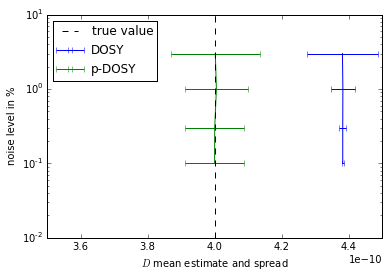

In [27]:
depnoise()

Figure S20

Comparison of DOSY and p-DOSY for different gradient list length

,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,438.912734,1.515282
2,40,438.227110,1.488769
3,80,437.944938,1.488432
4,160,437.793551,1.453846
5,320,437.705539,1.496912
,Grad Length,$<D>10^{-12}\mu m^2/sec^{-1}$,$\sigma_D$
0,theo.,400.000000,-
1,20,400.330948,12.95183
2,40,400.094093,8.68124


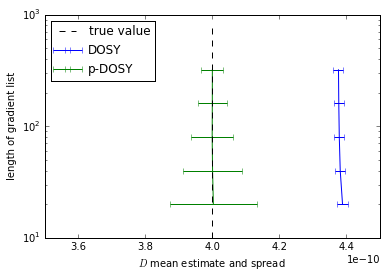

In [28]:
depglength(partial(KinSecond, T2=300))